<a href="https://colab.research.google.com/github/FSMLP/DLP101/blob/main/Proj_A_Linear_Regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **About**

This notebook aims at understanding the basics of PyTorch by implementing **Simple Linear Regression** and **Multivariate Linear Regression** from scratch. Although self-sufficient, the jupyter notebook can be best understood when followed along with [The Complete PyTorch Mastery Course 2021](https://). The whole exercise can be roughly divided into following sections:


1. ***Synthesize*** Random Data Points for Univariate and Multivariate Linear Regression
2. ***Visualize*** Generated Data Points in 2-D and 3-D plane respectively
3. ***Initialize*** Weights and Biases for Regression models
4. ***Define*** regression models and loss function(s) and train the network using gradient descent
5. ***Visualize*** changes in loss values, weights and biases during training
6. ***Apply*** feature scaling and retrain the network

***Note:*** *This is NOT the recommended way of building models/training in PyTorch. It's just to illustrate how easy it is to transfer any mathematical expression and gradient calculations to PyTorch. In later modules of the course, we will **revisit** this problem and solve it again using standard conventions.*





# Prerequisites

You should have basic understanding of:


*   Univariate and Multivariate Linear Regression
*   Cost/Loss functions used for regression (e.g. Mean Squared Error, Mean Absolute Error, etc.)
*   Gradient Descent
*   Feature Scaling (Normalization, Standardization, etc.)



#  0. Setup

In [ ]:
# Import statements
# use "%matplotlib notebook" for interacting with 3d graphs in local machine
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import nn

# Define Global Variable to determine which device to put the tensors 
# and learnable parameters on! 
device = 'cpu'
if torch.cuda.is_available():
    device='cuda'

# Always set manual seed value for reproducibility
torch.random.manual_seed(22);

# 1. Synthesize Data

Use `torch.rand` to generate **100** random samples each for the amount of food intake per day in calories i.e. `x_food` and total exercise duration per day in min i.e. `x_play`. We define the ranges for each input variable and use formula
() to generate sample random values from uniform distribution in that range. 

In [ ]:
sample_size = 100

# Create a random uniform distribution of shape [sample_size,2] where 2 is the # of features
uniform_dist = torch.rand((sample_size,2))

# Define range for food intake data in calories and slice from the uniform distribution
food_range = [1, 3]
x_food = (food_range[1] - food_range[0]) * uniform_dist[:,0] + food_range[0]

# Define range for play/exercise data in mins and slice from the uniform distribution
play_range = [0, 300]
x_play = (play_range[1] - play_range[0]) * uniform_dist[:,1] + play_range[0]

# Generate gaussian noise
noise = torch.randn(sample_size) * 5

# Create ground truth for univariate and multivariate distribution.
# Note the value of w_food_hat, w_play_hat and b here. 
# You can select any values for these and the model should be able to learn them.
w_food_hat = 45
w_play_hat = -0.12
b_hat = 20

# Create targets
y_uni_hat = ( w_food_hat * x_food  +  b_hat  )  +  noise
y_multi_hat = ( w_food_hat * x_food  +  w_play_hat * x_play  +  b_hat )  +  noise

# 2. Visualize Data

In this section, we will plot the `y_uni_hat` vs `x_food` on a 2D scatter plot and `y_multi_hat` vs \{`x_food`, `x_play`\} on a 3D scatter plot!

## a. 2D Scatter Plot

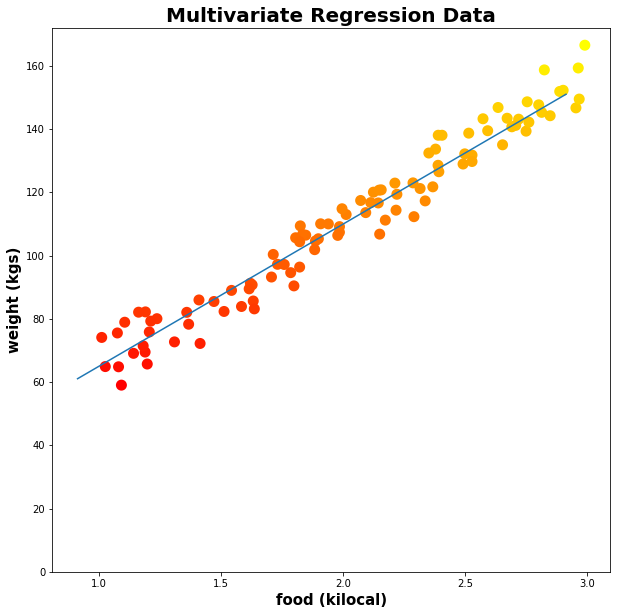

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

# plot scatter points
ax.scatter(x_food, y_uni_hat, c=y_uni_hat, cmap='autumn', linewidths=5)
plt.title("Multivariate Regression Data", fontsize=20, fontweight='bold')
ax.set_xlabel("food (kilocal)", fontsize=15, fontweight='bold')
ax.set_ylabel("weight (kgs)", fontsize=15, fontweight='bold')
ax.set_ylim(bottom=0)
# plot regression line
xlim = ax.get_xlim()
X = torch.arange(xlim[0], xlim[1])
Y = w_food_hat * X + b_hat # Equation of line without noise
ax.plot(X, Y)
plt.show()

## b. 3D Scatter Plot

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


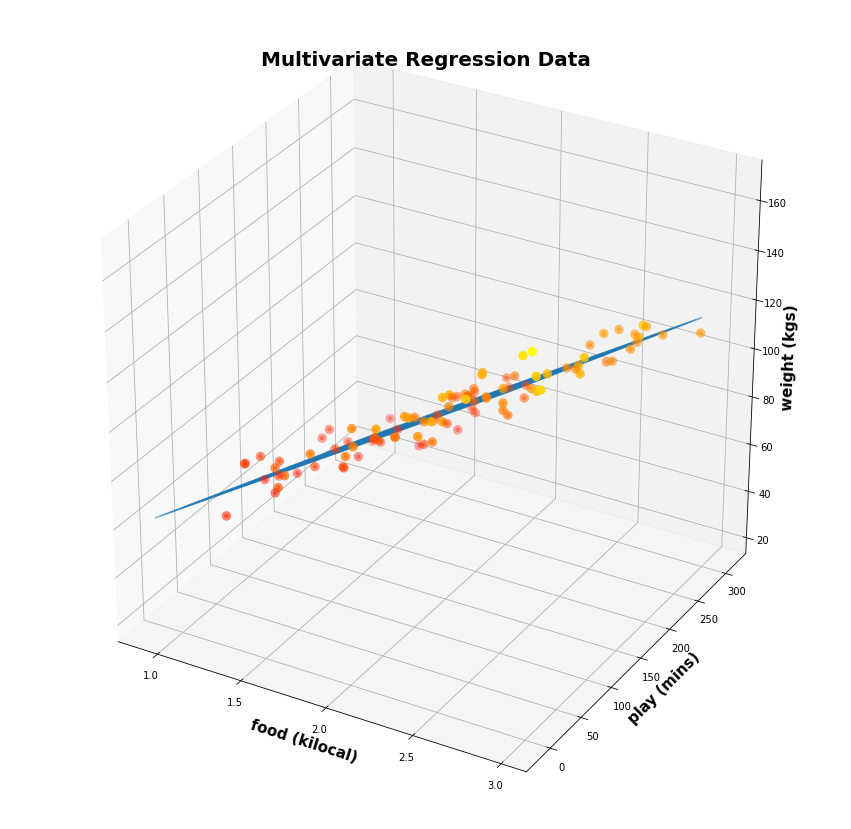

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# plot scatter points
ax.scatter3D(x_food, x_play, y_multi_hat, c=y_multi_hat, cmap='autumn', linewidths=5)
plt.title("Multivariate Regression Data", fontsize=20, fontweight='bold')
ax.set_xlabel("food (kilocal)", fontsize=15, fontweight='bold')
ax.set_ylabel("play (mins)", fontsize=15, fontweight='bold')
ax.set_zlabel("weight (kgs)", fontsize=15, fontweight='bold')

# plot regression plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X1,X2 = torch.meshgrid(torch.arange(xlim[0], xlim[1]),
                  torch.arange(ylim[0], ylim[1]))

Z = w_food_hat * X1 + w_play_hat * X2 + b_hat # Equation of line without noisy data
ax.plot_wireframe(X1, X2, Z, alpha=0.3)

#show plot
plt.show()

# 3. Univariate Regression

### This section implements simple linear regression from scratch in PyTorch.

Regression models describe the relationship between variables by fitting a line to the observed data. This allows us to estimate how a dependent variable changes as the independent variable(s) change.

> ![slr.png](https://miro.medium.com/max/500/0*gglavDlTUWKn4Loe)

The formula for a simple regression is:

> ![slr2.png](https://cdn.scribbr.com/wp-content/uploads/2020/02/simple-linear-regression-formula.png)  

where,
* **y** is the predicted value of the dependent variable (**y**) for any given value of the independent variable (**x**).
* **B0** is the intercept, the predicted value of y when the x is 0.
* **B1** is the regression coefficient – how much we expect y to change as x increases.
* **x** is the independent variable ( the variable we expect is influencing y).
* **e** is the error of the estimate, or how much variation there is in our estimate of the regression coefficient.

Linear regression finds the line of best fit line through your data by searching for the regression coefficient (B1) that minimizes the total error (e) of the model.
      
Regression problems can either be solved [directly](https://www.wired.com/2011/01/linear-regression-by-hand/) using closed-form solutions or iteratively using gradient descent. Gradient Descent is the preferred method as it is not only computationally cheaper and scales well with increasing data and variables, but its simplicity and robustness makes it ubiquitous in any optimization problem (even for non-convex problems). See [this](https://stats.stackexchange.com/questions/278755/why-use-gradient-descent-for-linear-regression-when-a-closed-form-math-solution) and [this](https://stats.stackexchange.com/questions/160179/do-we-need-gradient-descent-to-find-the-coefficients-of-a-linear-regression-mode) for discussion around it. 

In **part a.** we solve analytically by applying ordinary least squares method to calculate the coefficients as follows,

Lets assume eqn. of straight line is given by,

> ![Eqn.png](https://alexisalulemacom.files.wordpress.com/2018/01/lser_01.png?w=177&h=34)

Then, for all data points (xi, yi) we have to minimize the sum of the squared errors:
> ![eqn.png](https://alexisalulemacom.files.wordpress.com/2018/01/lser_02.png?w=608&h=109)

With a bit of manipulation we get:

> ![eqn2.png](https://alexisalulemacom.files.wordpress.com/2018/01/lser_03.png?w=554&h=276)

Thus, 
> ![eqn3.png](https://alexisalulemacom.files.wordpress.com/2018/01/lser_04.png)

In **part b.** we first initialize the parameters(weights and biases), move the tensors to "device" and then calculate loss and perform gradient descent iteratively to optimize network parameters and obtain the coefficients.

## a. [Direct Solver] Using Ordinary Least Squares (OLS)

In [ ]:
x = x_food
Y = y_uni_hat

# Add column of ones corresponding to b variable
X = torch.stack((x, torch.ones(len(x)))).T
XtX_inv = torch.inverse(X.T @ X)
A = XtX_inv @ X.T @ Y

print(f'Using Ordinary Least Squares:\t w_food: {A[0]},\t b:{A[1]}')

Using Ordinary Least Squares:	 w_food: 46.193199157714844,	 b:17.677152633666992


## b. [Iterative Method] Using Gradient Descent

In [ ]:
# Initialize the weights and biases for simple linear regression model
w_food = torch.rand(1, device=device, requires_grad=True)
b = torch.rand(1, device=device, requires_grad=True)

lr = 1e-4
num_epochs = 10000

# Move the input and output tensors to device
x = x_food.to(device)
y_uni_hat = y_uni_hat.to(device)

# The lists will store values for future visualizations
loss_list = []
w_food_list = []
b_list = []
for i in range(num_epochs):
    # Simple Regression equation
    y_uni = w_food * x  +  b 

    # Mean Squared Error
    loss = torch.mean((y_uni_hat - y_uni)**2)

    # Calculate Gradient of Loss w.r.t weights and biases
    grad_food, grad_b = torch.autograd.grad(loss, [w_food,b])
    # Update the weights and biases using batch gradient descent
    w_food = w_food - grad_food * lr
    b = b - grad_b * lr

    # Append to the list
    # loss_list.append(loss)
    # w_food_list.append(w_food)
    # b_list.append(b)

    # Although appending pytorch tensors would work just fine in our case, it is generally
    # recommended to convert the tensors into numpy arrays for post-processing/visualization 
    # to avoid any bugs because of it
    with torch.no_grad():
        loss_list.append(loss.cpu().numpy())
        w_food_list.append(w_food.cpu().numpy())
        b_list.append(b.cpu().numpy())

    # Print loss every 500 epoch
    if i%500 == 0:
        print(f'Iter: {i},\t Loss: {loss},\t w_food: {w_food[0]},\t b:{b[0]}')

Iter: 0,	 Loss: 12703.4990234375,	 w_food: 0.35328221321105957,	 b:0.746331512928009
Iter: 500,	 Loss: 4389.92041015625,	 w_food: 18.61425018310547,	 b:9.230430603027344
Iter: 1000,	 Loss: 1529.7169189453125,	 w_food: 29.329273223876953,	 b:14.19800853729248
Iter: 1500,	 Loss: 545.6854858398438,	 w_food: 35.61823654174805,	 b:17.103038787841797
Iter: 2000,	 Loss: 207.1376953125,	 w_food: 39.31098937988281,	 b:18.798330307006836
Iter: 2500,	 Loss: 90.65707397460938,	 w_food: 41.480960845947266,	 b:19.78409767150879
Iter: 3000,	 Loss: 50.575016021728516,	 w_food: 42.75775909423828,	 b:20.353778839111328
Iter: 3500,	 Loss: 36.77842712402344,	 w_food: 43.51061248779297,	 b:20.6794376373291
Iter: 4000,	 Loss: 32.02492904663086,	 w_food: 43.956153869628906,	 b:20.862010955810547
Iter: 4500,	 Loss: 30.382944107055664,	 w_food: 44.22138977050781,	 b:20.960708618164062
Iter: 5000,	 Loss: 29.81145477294922,	 w_food: 44.380855560302734,	 b:21.0102596282959
Iter: 5500,	 Loss: 29.608373641967773,	 

### Plot Results

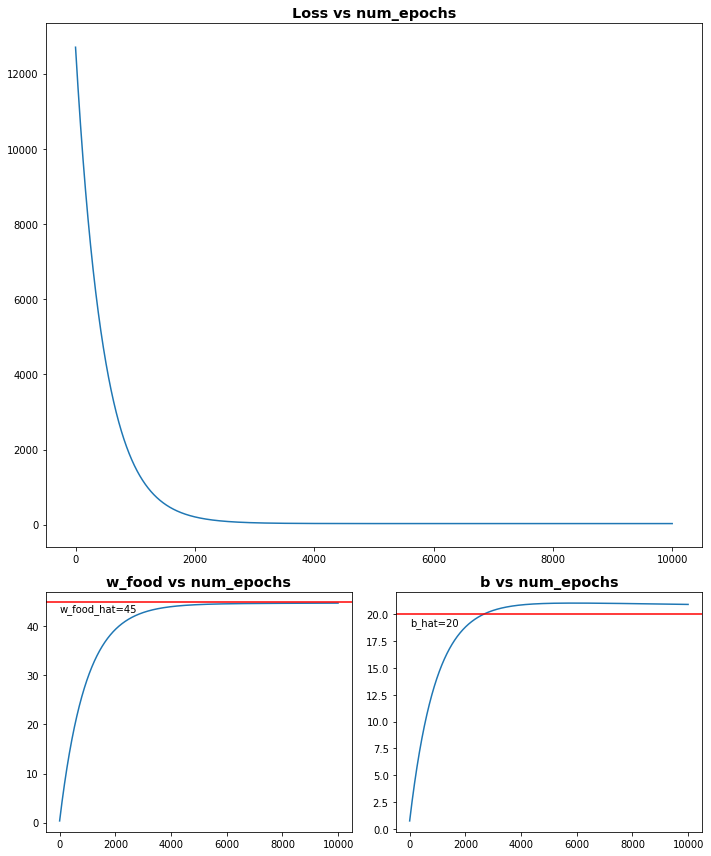

In [ ]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(12)

plot_loss = plt.subplot2grid((6,4), (0,0), colspan=4, rowspan=4)
plot_w = plt.subplot2grid((6,4), (4,0), colspan=2, rowspan=2)
plot_b = plt.subplot2grid((6,4), (4,2), colspan=2, rowspan=2)

# x axis of all plots
epochs = torch.arange(0,num_epochs)

# loss on y axis of plot #1
plot_loss.plot(epochs, loss_list)
plot_loss.set_title('Loss vs num_epochs', fontweight="bold", fontsize="x-large")

# w_food on y axis of plot #2
plot_w.plot(epochs, w_food_list)
plot_w.set_title('w_food vs num_epochs', fontweight="bold", fontsize="x-large")
# plot horizontal line showing ground truth value i.e. w_food_hat
plot_w.axhline(w_food_hat, color='r')
plot_w.text(0, w_food_hat-2, f'w_food_hat={w_food_hat}')

# b on y axis of plot #3
plot_b.plot(epochs, b_list)
plot_b.set_title('b vs num_epochs', fontweight="bold", fontsize="x-large")
# plot horizontal line showing ground truth value i.e. b_hat
plot_b.axhline(b_hat, color='r')
plot_b.text(0, b_hat-1, f'b_hat={b_hat}')

plt.tight_layout()
plt.show()

# 4. Multivariate Regression

### In this section we implement multivariate regression from scratch. We also show the role of feature scaling in training regression models using gradient descent.


Multivariate Linear regression can be expressed as:

> ![image.png](https://miro.medium.com/max/439/1*DYz_sFbSii0x8O3SXFOyjw.png)

where, 

> ![linear.png](https://miro.medium.com/max/259/1*Xyst_JGKlQ3hO55MS7_drg.png)

The parameters carry the same meaning as in the univariate regression case.

We will solve the multivariate regression case in an identical way to that of univariate. But this time we introduce the concept of normalization of input data and its impact on training. Thus, we have divided it into two sections:

In **part a.** we operate on the given input data without any transformation. while in **part b.** we use normalized data to boost training, yielding faster convergence.

## a. Without Data Normalization

In [ ]:
# Initialize the weights and biases for multivariate regression model
w_food = torch.rand(1, device=device, requires_grad=True)
w_play = torch.rand(1, device=device, requires_grad=True)
b = torch.rand(1, device=device, requires_grad=True)

lr = 2*1e-5
num_epochs = 10000

# Move the input and output tensors to device
x1 = x_food.to(device)
x2 = x_play.to(device)
y_multi_hat = y_multi_hat.to(device)

# Define lists for visualization purpose
loss_list = []
w_food_list = []
w_play_list = []
b_list = []
for i in range(num_epochs):
    # Multivariate Regression Equation
    y_multi = w_food * x1  +  w_play * x2  +  b 

    # Mean Squared Error
    loss = torch.mean((y_multi_hat - y_multi.squeeze())**2)
    
    # Calculate Gradient of Loss w.r.t weights and biases
    grad_food, grad_play, grad_b = torch.autograd.grad(loss, [w_food,w_play,b])

    # Update the weights and biases using batch gradient descent
    w_food = w_food - grad_food * lr
    w_play = w_play - grad_play * lr
    b = b - grad_b * lr

    # Append numpy tensors to list
    with torch.no_grad():
        loss_list.append(loss.cpu().numpy())
        w_food_list.append(w_food.cpu().numpy())
        w_play_list.append(w_play.cpu().numpy())
        b_list.append(b.cpu().numpy())

    # Print loss every 500 epoch
    # w_food, w_play = w
    if i%500 == 0:
        print(f'Iter: {i},\t Loss: {loss},\t w_food: {w_food[0]},\t w_play: {w_play[0]},\t b:{b[0]}')

Iter: 0,	 Loss: 4021.07373046875,	 w_food: 0.7217021584510803,	 w_play: 0.40286457538604736,	 b:0.38271284103393555
Iter: 500,	 Loss: 3449.512451171875,	 w_food: 2.077812910079956,	 w_play: 0.40853196382522583,	 b:0.9175271987915039
Iter: 1000,	 Loss: 3249.4423828125,	 w_food: 3.3934526443481445,	 w_play: 0.3926128149032593,	 b:1.4363770484924316
Iter: 1500,	 Loss: 3061.072265625,	 w_food: 4.670039176940918,	 w_play: 0.37716612219810486,	 b:1.9398444890975952
Iter: 2000,	 Loss: 2883.716796875,	 w_food: 5.908731937408447,	 w_play: 0.36217784881591797,	 b:2.428386688232422
Iter: 2500,	 Loss: 2716.733154296875,	 w_food: 7.110654830932617,	 w_play: 0.3476344048976898,	 b:2.90244197845459
Iter: 3000,	 Loss: 2559.51416015625,	 w_food: 8.276900291442871,	 w_play: 0.33352258801460266,	 b:3.3624441623687744
Iter: 3500,	 Loss: 2411.489013671875,	 w_food: 9.408523559570312,	 w_play: 0.3198296129703522,	 b:3.8088090419769287
Iter: 4000,	 Loss: 2272.119873046875,	 w_food: 10.506558418273926,	 w_pla

### Plot Results

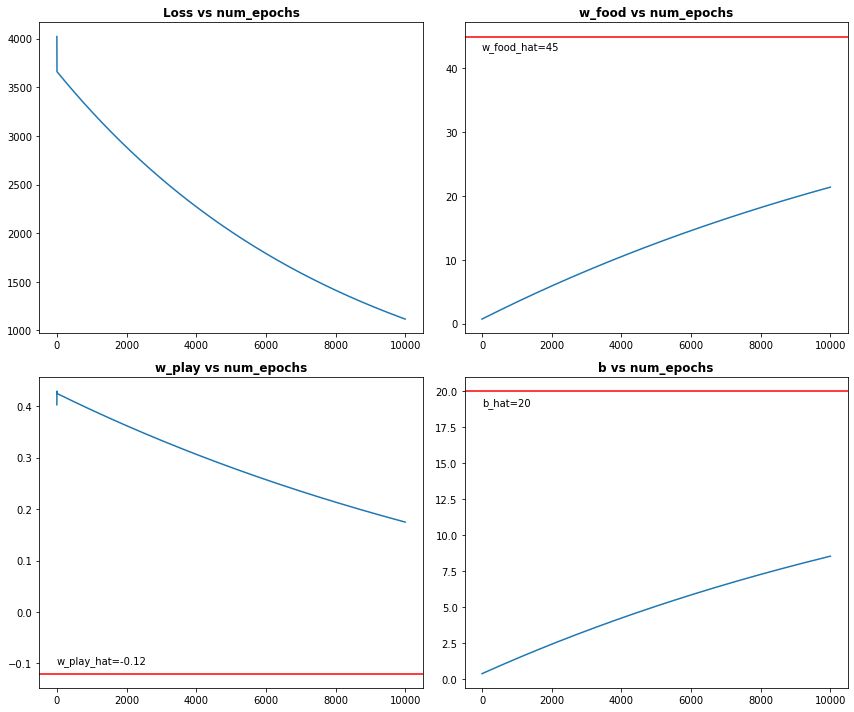

In [ ]:
fig, a = plt.subplots(2,2)
plot_loss, plot_w1 = a[0]
plot_w2, plot_b = a[1]
fig.set_figwidth(12)
fig.set_figheight(10)

# x axis of all plots
epochs = torch.arange(0,num_epochs)

# loss on y axis of plot #1
plot_loss.plot(epochs, loss_list)
plot_loss.set_title('Loss vs num_epochs', fontweight="bold", fontsize="large")

# w_food on y axis of plot #2
plot_w1.plot(epochs, w_food_list)
plot_w1.set_title('w_food vs num_epochs', fontweight="bold", fontsize="large")
plot_w1.axhline(w_food_hat, color='r')
plot_w1.text(0, w_food_hat-2, f'w_food_hat={w_food_hat}')

# w_play on y axis of plot #3
plot_w2.plot(epochs, w_play_list)
plot_w2.set_title('w_play vs num_epochs', fontweight="bold", fontsize="large")
plot_w2.axhline(w_play_hat, color='r')
plot_w2.text(0, w_play_hat+0.02, f'w_play_hat={w_play_hat}')

# b on y axis of plot #4
plot_b.plot(epochs, b_list)
plot_b.set_title('b vs num_epochs', fontweight="bold", fontsize="large")
plot_b.axhline(b_hat, color='r')
plot_b.text(0, b_hat-1, f'b_hat={b_hat}')

plt.tight_layout()
plt.show()

## b. With Data Normalization

In [ ]:
# Define a Weights matrix(including bias)
W = torch.rand([3,1], device=device, requires_grad=True) # Look at the equation for intuitive understanding

lr = 1e-3
num_epochs = 10000

# Normalize the Input tensors with O mean and 1 std
x = torch.stack((x_food,x_play))
x_means = x.mean(1, keepdim=True)
x_stds = x.std(1, keepdim=True)
x_norm = ((x - x_means) / x_stds)

# concatenete ones to the normalized input tensor for bias calculation. See formula!
x_bias = torch.cat((torch.ones(sample_size).unsqueeze(dim=0), x_norm)).T #Transpose the results

# Move input and output tensors to device
x_bias = x_bias.to(device)
y_multi_hat = y_multi_hat.to(device)

# Define list of variables to be cached for future visualizations.
loss_list = []
w_food_list = []
w_play_list = []
b_list = []

for i in range(num_epochs):
    # Multivariate regression equation in Matrix form
    y_multi = x_bias @ W 

    # Mean Squared Error
    loss = torch.mean((y_multi_hat - y_multi.squeeze())**2)
    loss_list.append(loss)

    # Calculate Gradient of Loss w.r.t weights and biases
    grad = torch.autograd.grad(loss, W)

    # Update the weights and biases using batch gradient descent
    W = W - grad[0] * lr

    # Postprocessing
    # Rescaling after feature scaling
    with torch.no_grad():
        b, w_food, w_play = W.clone().cpu()
        w_food /= x_stds[0]
        w_play /= x_stds[1]

        b -= w_food*x_means[0] + w_play*x_means[1]

        w_food_list.append(w_food.numpy())
        w_play_list.append(w_play.numpy())
        b_list.append(b.numpy())
        if i%500 == 0:
            print(f'Iter: {i},\t Loss: {loss},\t w_food: {w_food[0]},\t w_play: {w_play[0]},\t b:{b[0]}')

Iter: 0,	 Loss: 9407.6171875,	 w_food: 0.2537829279899597,	 w_play: 0.00890599749982357,	 b:-1.3934805393218994
Iter: 500,	 Loss: 1299.1114501953125,	 w_food: 29.058460235595703,	 w_play: -0.0761287659406662,	 b:11.703033447265625
Iter: 1000,	 Loss: 200.39515686035156,	 w_food: 39.80733108520508,	 w_play: -0.108495332300663,	 b:16.355133056640625
Iter: 1500,	 Loss: 51.496788024902344,	 w_food: 43.81886672973633,	 w_play: -0.12080889195203781,	 b:18.004226684570312
Iter: 2000,	 Loss: 31.315282821655273,	 w_food: 45.316104888916016,	 w_play: -0.12549138069152832,	 b:18.58759307861328
Iter: 2500,	 Loss: 28.579557418823242,	 w_food: 45.87500762939453,	 w_play: -0.12727120518684387,	 b:18.793357849121094
Iter: 3000,	 Loss: 28.208637237548828,	 w_food: 46.08364486694336,	 w_play: -0.1279473751783371,	 b:18.865806579589844
Iter: 3500,	 Loss: 28.158342361450195,	 w_food: 46.16154098510742,	 w_play: -0.12820422649383545,	 b:18.891189575195312
Iter: 4000,	 Loss: 28.151517868041992,	 w_food: 46.1

### Plot Results

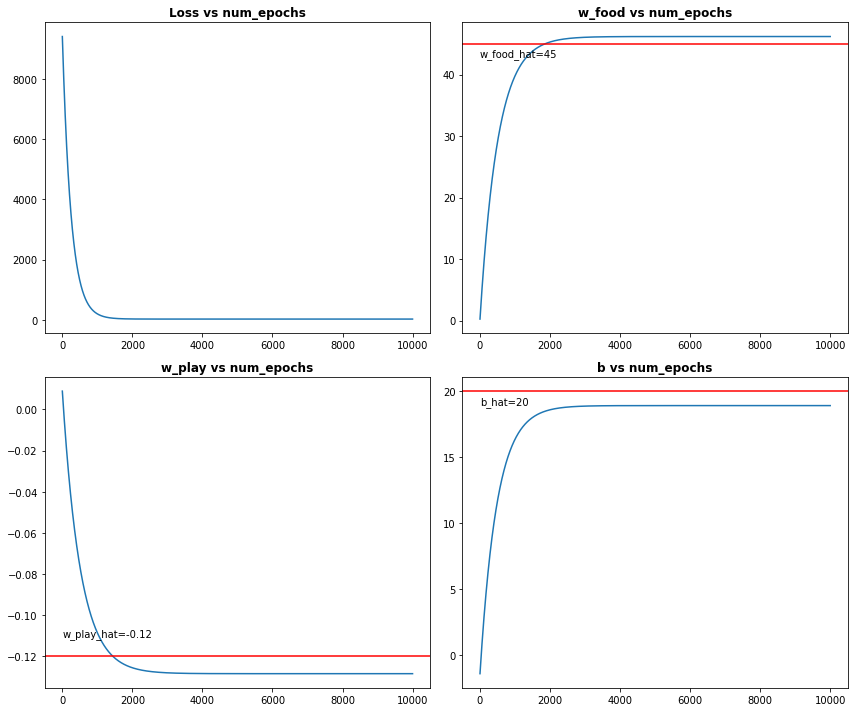

In [ ]:
fig, a = plt.subplots(2,2)
plot_loss, plot_w1 = a[0]
plot_w2, plot_b = a[1]
fig.set_figwidth(12)
fig.set_figheight(10)

epochs = torch.arange(0,num_epochs)

plot_loss.plot(epochs, loss_list)
plot_loss.set_title('Loss vs num_epochs', fontweight="bold", fontsize="large")
plot_w1.plot(epochs, w_food_list)
plot_w1.set_title('w_food vs num_epochs', fontweight="bold", fontsize="large")
plot_w1.axhline(w_food_hat, color='r')
plot_w1.text(0, w_food_hat-2, f'w_food_hat={w_food_hat}')
plot_w2.plot(epochs, w_play_list)
plot_w2.set_title('w_play vs num_epochs', fontweight="bold", fontsize="large")
plot_w2.axhline(w_play_hat, color='r')
plot_w2.text(0, w_play_hat+0.01, f'w_play_hat={w_play_hat}')
plot_b.plot(epochs, b_list)
plot_b.set_title('b vs num_epochs', fontweight="bold", fontsize="large")
plot_b.axhline(b_hat, color='r')
plot_b.text(0, b_hat-1, f'b_hat={b_hat}')

plt.tight_layout()
plt.show()

# [Optional] Implement 1 hidden-layer Neural Network! 

In this exercise we will be implementing one-hidden layer neural network with 5 neurons as shown below. 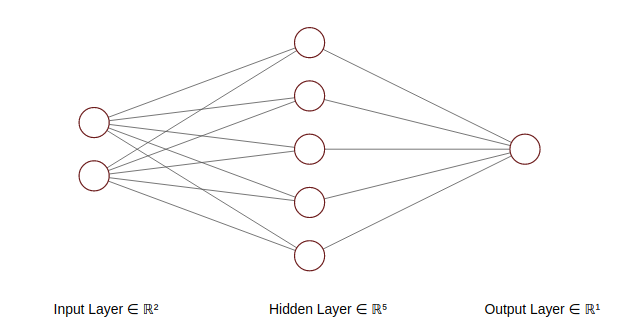

We will also add relu non-linearity for the hidden layer.  

## a. Train the network

In [ ]:
# Initialize Weights and Biases 
W1 = torch.rand([2,5], device=device, requires_grad=True)
b1 = torch.rand([1,], device=device, requires_grad=True)
W2 = torch.rand([5,1], device=device, requires_grad=True)
b2 = torch.rand([1,], device=device, requires_grad=True)

lr = 1e-4
num_epochs = 10000

# Normalize the Input tensors with O mean and 1 std
x = torch.stack((x_food,x_play))
x_means = x.mean(1, keepdim=True)
x_stds = x.std(1, keepdim=True)
x_norm = ((x - x_means) / x_stds).T

# Move input and output tensors to device
x_norm = x_norm.to(device)
y_multi_hat = y_multi_hat.to(device)


for i in range(num_epochs):
    # Multivariate regression equation in Matrix form
    y1 = x_norm @ W1 + b1 
    relu1 = torch.maximum(torch.tensor([0], device=device), y1)
    y2 = relu1 @ W2 + b2

    # Mean Squared Error
    loss = torch.mean((y_multi_hat - y2.squeeze())**2)

    # Calculate Gradient of Loss w.r.t weights and biases
    grad = torch.autograd.grad(loss, [W1,W2,b1,b2])

    # Update the weights and biases using batch gradient descent
    W1 = W1 - grad[0] * lr
    W2 = W2 - grad[1] * lr
    b1 = b1 - grad[2] * lr
    b2 = b2 - grad[3] * lr

    if i%500 == 0:
        print(f'Iter: {i},\t Loss: {loss}')

Iter: 0,	 Loss: 9181.646484375
Iter: 500,	 Loss: 28.257949829101562
Iter: 1000,	 Loss: 28.15045166015625
Iter: 1500,	 Loss: 28.150442123413086
Iter: 2000,	 Loss: 28.15044593811035
Iter: 2500,	 Loss: 28.15044593811035
Iter: 3000,	 Loss: 28.15044593811035
Iter: 3500,	 Loss: 28.15044593811035
Iter: 4000,	 Loss: 28.15044593811035
Iter: 4500,	 Loss: 28.15044593811035
Iter: 5000,	 Loss: 28.15044593811035
Iter: 5500,	 Loss: 28.15044593811035
Iter: 6000,	 Loss: 28.15044593811035
Iter: 6500,	 Loss: 28.15044593811035
Iter: 7000,	 Loss: 28.15044593811035
Iter: 7500,	 Loss: 28.15044593811035
Iter: 8000,	 Loss: 28.15044593811035
Iter: 8500,	 Loss: 28.15044593811035
Iter: 9000,	 Loss: 28.15044593811035
Iter: 9500,	 Loss: 28.15044593811035


## b. Test on new random data

Generate new dataset from the same distribution as that of synthetic dataset and do forward pass on the regression equation.  
Calculate Mean Squared Error.

In [ ]:
# Create a random uniform distribution of shape [sample_size,2] where 2 is the # of features
uniform_dist = torch.rand((50,2))

# Define range for food intake data in calories and slice from the uniform distribution
food_range = [3, 5]
x_food_test = (food_range[1] - food_range[0]) * uniform_dist[:,0] + food_range[0]

# Define range for play/exercise data in mins and slice from the uniform distribution
play_range = [200, 250]
x_play_test = (play_range[1] - play_range[0]) * uniform_dist[:,1] + play_range[0]

# Generate gaussian noise
noise = torch.randn(50) * 5

# Generate Ground-Truth  labels
y_test_hat = w_food_hat * x_food_test  +  w_play_hat * x_play_test  +  b_hat + noise

# Normalize input data
x_test = torch.stack((x_food_test,x_play_test))
x_means = x.mean(1, keepdim=True)
x_stds = x.std(1, keepdim=True)
x_norm_test = ((x_test - x_means) / x_stds).T

# Move input and ground truth tensors to device
x_norm_test = x_norm_test.to(device)
y_test_hat = y_test_hat.to(device)

# Calculate Mean Squared error w.r.t. ground truth
# Multivariate regression equation in Matrix form
with torch.no_grad():
    y1 = x_norm_test @ W1 + b1 
    relu1 = torch.maximum(torch.tensor([0], device='cuda'), y1)
    y_test = relu1 @ W2 + b2

    # Mean Squared Error
    error = torch.mean((y_test_hat - y_test.squeeze())**2)

print(f'Error on test data: {error}')

### Visualize Predictions on Test Dataset

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# plot scatter points
ax.scatter3D(x_food_test.cpu(), x_play_test.cpu(), y_test.cpu(), linewidths=5)
plt.title("Multivariate Regression Data", fontsize=20, fontweight='bold')
ax.set_xlabel("food (kilocal)", fontsize=15, fontweight='bold')
ax.set_ylabel("play (mins)", fontsize=15, fontweight='bold')
ax.set_zlabel("weight (kgs)", fontsize=15, fontweight='bold')

# plot regression plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X1,X2 = torch.meshgrid(torch.arange(xlim[0], xlim[1]),
                  torch.arange(ylim[0], ylim[1]))

Z = w_food_hat * X1 + w_play_hat * X2 + b_hat # Equation of line without noisy data
ax.plot_wireframe(X1, X2, Z, alpha=0.3, color = 'm')

#show plot
plt.show()